In [ ]:
pip show tensorflow


Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl, tf_keras


In [ ]:
import os
import pandas as pd
import re
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.activations import linear, relu, sigmoid, softmax
from tensorflow.keras.optimizers import*
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import Dense, BatchNormalization


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving dataset_preflop_final-3.csv to dataset_preflop_final-3.csv


In [ ]:
df = pd.read_csv("dataset_preflop_final-3.csv", header = 0)
#data = df.drop(columns = ["hand_id", "nb_start"])
df
print("Nombre de lignes dans le DataFrame:", df.shape[0])
print("Nombre de lignes dans le fichier CSV:", sum(1 for line in open("dataset_preflop_final-3.csv")) - 1)  # -1 pour l'en-tête


Nombre de lignes dans le DataFrame: 42661
Nombre de lignes dans le fichier CSV: 42661


In [ ]:
pip install --upgrade tensorflow

In [ ]:
df["top_card"] = 0
df["cards_gap"] = 0
df["same_color"] = 0
df['decision'] = df['decision'].replace({'checks': 'calls', 'bets': 'raises'})
df

,game_id,stack,position,nb_players_start,cards,pot_size_before_decision,nb_unfolded_players,money_to_add_to_call,last_raise__preflop_player,mise en cas de raise/bet,decision,top_card,cards_gap,same_color
0,808941103,30.00,3,9,Jd Jc,2.50,7,1.00,-3,4.0,raises,0,0,0
1,808941103,26.00,0,9,Jd Jc,17.00,2,11.00,1,0.0,folds,0,0,0
2,808943744,30.00,6,9,9c Ac,1.50,9,1.00,-3,3.0,raises,0,0,0
3,808942446,30.00,5,9,6d 4d,1.50,8,1.00,-3,0.0,folds,0,0,0
4,808941818,30.00,4,9,7d Qc,1.50,7,1.00,-3,0.0,folds,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42656,788416663,15.00,0,6,5d 7h,3.25,5,1.25,2,0.0,folds,0,0,0
42657,788416369,59.00,2,7,2h Jd,8.00,3,4.00,0,0.0,folds,0,0,0
42658,788415505,58.00,1,6,5h 5c,9.00,2,4.00,0,0.0,calls,0,0,0
42659,788415209,14.75,-2,6,6d Qd,9.38,5,3.44,1,0.0,folds,0,0,0


In [ ]:
## TEST VALEURS ABERRANTES

data_trunc = df[:42500]
data_trunc = data_trunc.rename(columns={'cards_gap': 'bottom_card'} )

In [ ]:
cards = data_trunc["cards"]
#cards

def get_value(s):
  if s == 'A':
    return 14
  if s=='K':
    return 13
  if s== 'Q':
    return 12
  if s== 'J':
    return 11
  if (s == '1' ) | (s == 'T'):
    return 10
  return int(s)

for i in range(data_trunc.shape[0]):
  index = 0
  values = []
  c = data_trunc['cards'][i]
  if c[0] == "1":
    values.append(10)
    index+=1
  else :
    values.append(get_value(c[0]))

  index += 1
  values.append(c[index])
  index+=2
  if c[index] == "1":
    values.append(10)
    index+=1
  else :
    values.append(get_value(c[index]))

  index += 1
  values.append(c[index])
  data_trunc["top_card"][i] = max(values[0], values[2])
  data_trunc["same_color"][i] = (values[1] == values[3])
  data_trunc["bottom_card"][i] = min(values[0], values[2])

  if data_trunc['decision'][i] == 'folds' :
    data_trunc['decision'][i] = 0
  elif data_trunc['decision'][i] == 'calls' :
    data_trunc['decision'][i] = 1
  elif data_trunc['decision'][i] == 'raises' :
    data_trunc['decision'][i] = 2





Streaming output truncated to the last 5000 lines.
<ipython-input-69-6b92c27c2251>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_trunc['decision'][i] = 0
<ipython-input-69-6b92c27c2251>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_trunc["top_card"][i] = max(values[0], values[2])
<ipython-input-69-6b92c27c2251>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_trunc["bottom_card"][i] = min(values[0], values[2])
<

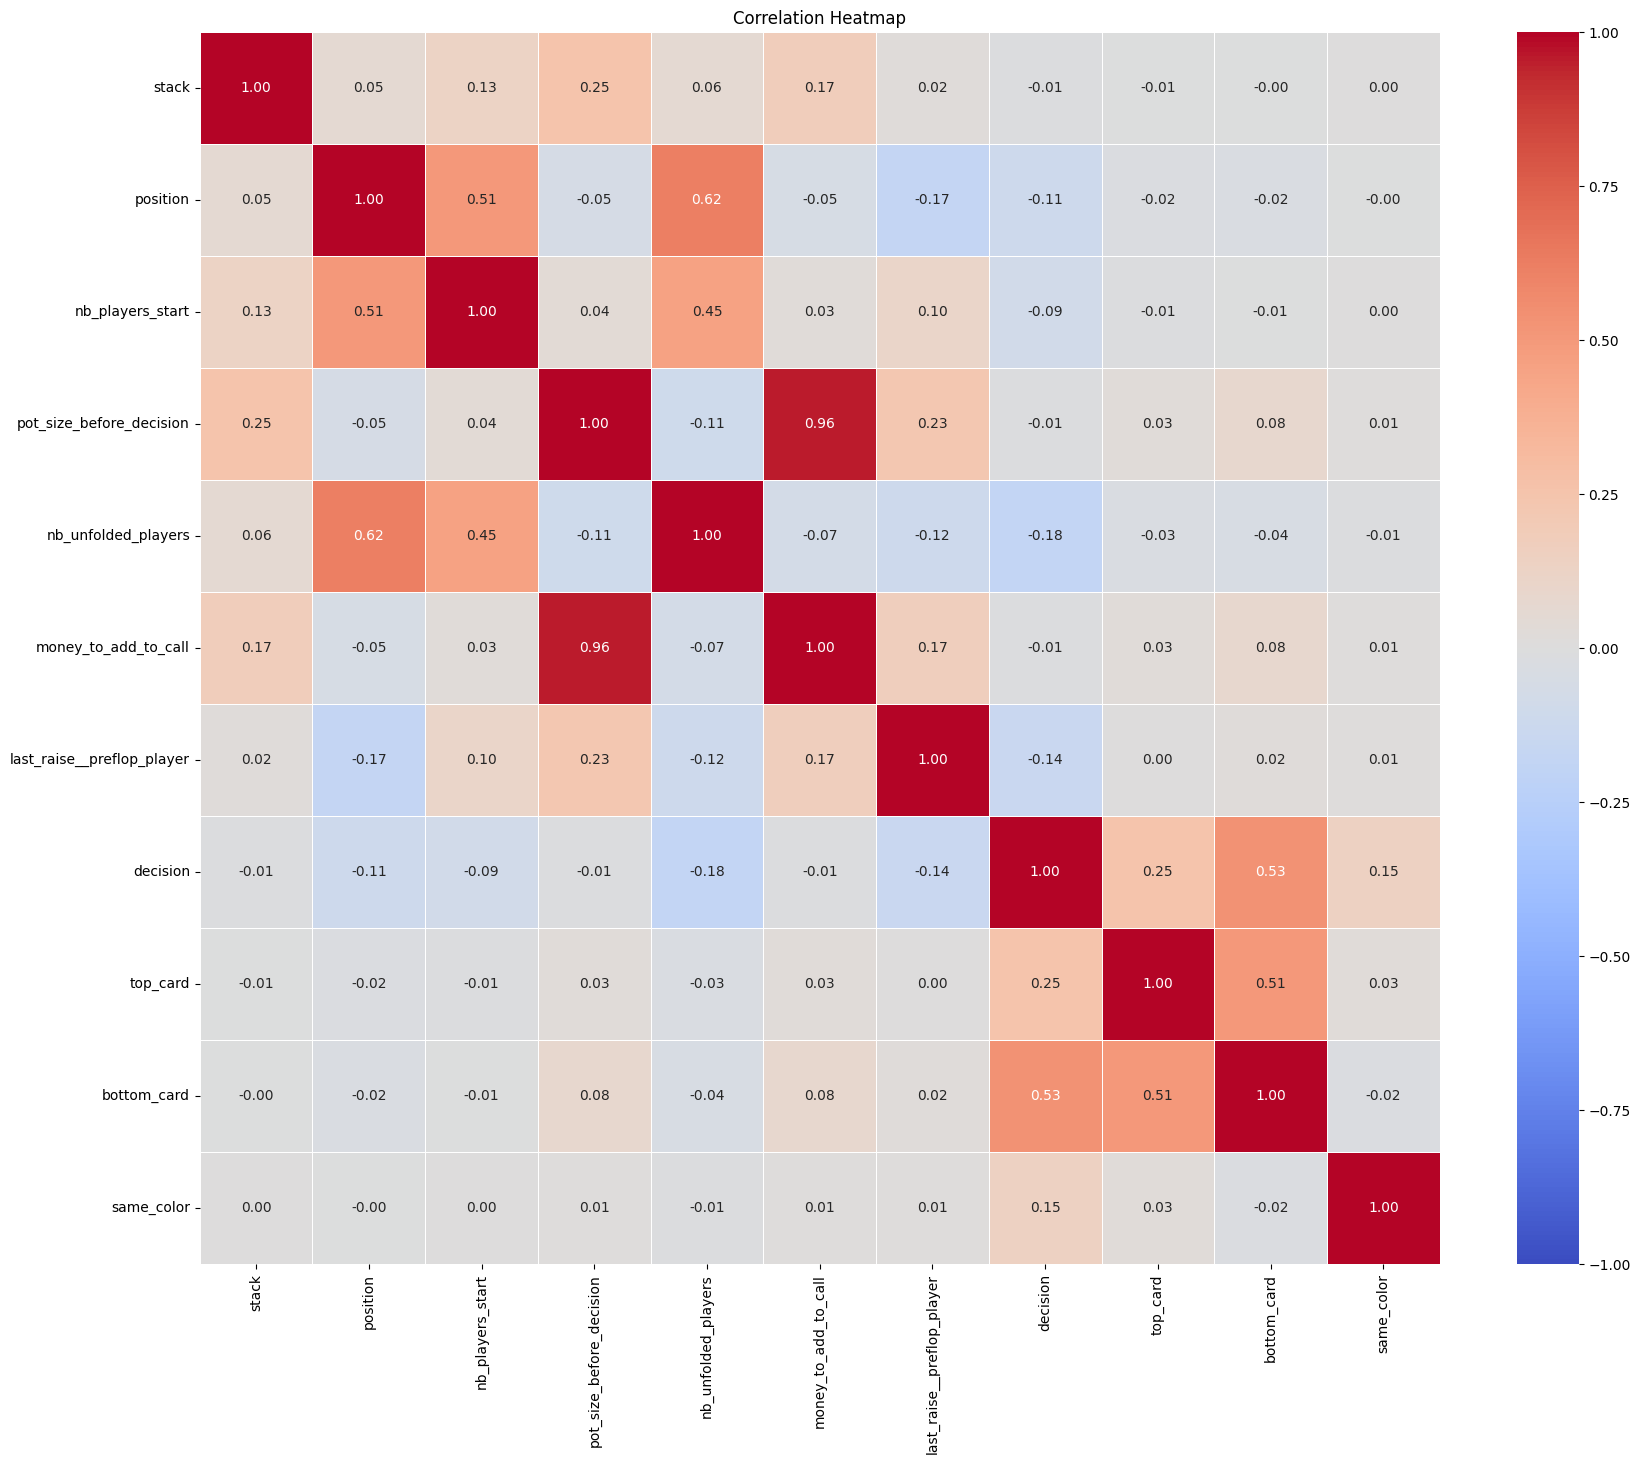

In [ ]:
data_trunc.rename(columns={'cards_gap': 'bottom_card'} )
feature = data_trunc.drop(columns=['game_id', 'cards','mise en cas de raise/bet'])
feature
M = feature.corr()


plt.figure(figsize=(20, 16))
sns.heatmap(M, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# Training
df = data_trunc.drop(columns=['game_id', 'decision', 'cards','mise en cas de raise/bet'])
features =df .values.astype(np.float32)
labels = data_trunc['decision']
labels = labels.values.astype(np.float32)
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, random_state = 42)
print(X_train.shape[1])
model = Sequential(
    [
      tf.keras.Input(shape=(X_train.shape[1],)),
      Dense(units=64,activation='relu',name='layer1'),
      Dropout(0.2),
      Dense(units=64,activation='relu',name='layer2'),
      Dropout(0.2),
      Dense(units=32,activation='relu',name='layer3'),

      Dense(units=3,activation='softmax',name='layer4')

    ], name = "preflop_model2"
)

df = data_trunc.drop(columns=['game_id', 'decision', 'cards','mise en cas de raise/bet'])
features =df .values.astype(np.float32)
labels = data_trunc['decision']
labels = labels.values.astype(np.float32)
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, random_state = 42)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = ['accuracy']
)

early_stopping = EarlyStopping(monitor='accuracy', patience=30, restore_best_weights=True)

history = model.fit(   X_train,Y_train,    epochs=1000, callbacks=[early_stopping], validation_data=(X_test, Y_test))


10
Epoch 1/1000
997/997 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7676 - loss: 0.6911 - val_accuracy: 0.8354 - val_loss: 0.4376
Epoch 2/1000
997/997 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8326 - loss: 0.4536 - val_accuracy: 0.8527 - val_loss: 0.3823
Epoch 3/1000
997/997 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8462 - loss: 0.4043 - val_accuracy: 0.8585 - val_loss: 0.3597
Epoch 4/1000
997/997 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8546 - loss: 0.3695 - val_accuracy: 0.8663 - val_loss: 0.3364
Epoch 5/1000
997/997 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8573 - loss: 0.3565 - val_accuracy: 0.8708 - val_loss: 0.3247
Epoch 6/1000
997/997 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8649 - loss: 0.3394 - val_accuracy: 0.8791 - val_loss: 0.3029
Epoch 7/1000
997/997 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8734 - loss: 0.3203 - val_accuracy: 0.8798 - val_loss: 0.2932
Epoch 8/1000
997/997 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8759 - loss: 0.3099

In [ ]:
a = max(history.history['accuracy'])
b = max(history.history['val_accuracy'])
print(a)
print(b)

0.9111843109130859
0.9060705900192261


333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


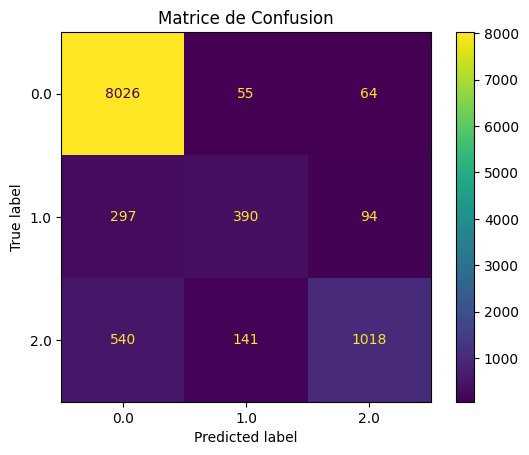

0.7408525361837617


In [ ]:
y_true = Y_test
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.title('Matrice de Confusion')
plt.show()

f1 = f1_score(y_true, y_pred, average='macro') # 'binary' pour classification binaire, 'macro' pour multi-classes
print(f1)


In [ ]:
a = max(history.history['accuracy'])
b = max(history.history['val_accuracy'])
b

0.9060705900192261

In [ ]:
model.save('mon_model2.h5')

In [ ]:
model.summary()

Model: "preflop_model2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                       │ (None, 64)                  │             704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer2 (Dense)                       │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer3 (Dense)                       │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer4 (Dense)                       │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,131 (82.55 KB)

 Trainable params: 7,043 (27.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,088 (55.04 KB)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model_path = '/content/drive/My Drive/mon_modele2.keras'
model.save(model_path)

In [ ]:
model_path = '/content/drive/My Drive/mon_modele22.h5'
model.save(model_path)


In [ ]:
model.save('mon_modele7.keras')  # Sauvegarde le modèle complet dans un fichier HDF5


In [ ]:
# Sauvegarde au format SavedModel
model.save('mon_modele_savedmodel', save_format='tf')


ValueError: The `save_format` argument is deprecated in Keras 3. Please remove this argument and pass a file path with either `.keras` or `.h5` extension.Received: save_format=tf

In [ ]:
mod=load_model('mon_modele7.h5') ##ca fonctionne bien
mod.summary()

Model: "preflop_model2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                       │ (None, 64)                  │             704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer2 (Dense)                       │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer3 (Dense)                       │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer4 (Dense)                       │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,045 (27.52 KB)

 Trainable params: 7,043 (27.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)